# Test multi-dimensional benchmark

In [1]:
import torch
import torch.autograd as autograd

import sys
import gc
import os
sys.path.append("..")

#from src.distributions import Motion_
from src.plotters import PCA_plot_q_p_samples 
from src.models import MinFunnels, Critic, Critic_sort
from src.utils import lipschitz_one_checker
from src.map_benchmark import MixToOneBenchmark
from src.methods import   train_WGAN, train_CoWGAN , train_LSOT, train_3PWGAN, train_WGAN_qp,\
                        calculate_unbiased_wasserstein, calculate_kantorovitch_wasserstein, DOT_metrics, \
                        L2_metrics, cosine_metrics
                        
                        

from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DIM = 16
DEG = 8
WIDTH = 16
SEED = 2
GPU_DEVICE = 1
 

In [3]:
torch.cuda.set_device(GPU_DEVICE)

In [4]:
benchmark =  MixToOneBenchmark(dim=DIM, width=WIDTH)

In [6]:
#======= COMMON =======

NUM_SAMPLES_PLOT_PCA = 1000
BATCH_SIZE = 1024
METRIC_SIZE = 2**12
 
LR = 2e-4
HIDDEN_DIMS  = [DIM,max(2*DIM,128),max(2*DIM,128),1] 

#======== WGAN =========
BOUND =  0.04
NUM_ITERATIONS_WGAN = 5000

#======= WGAN-GP ======
LAMBDA_GP = 10.
NUM_ITERATIONS_WGAN_GP = 40000

#======= WGAN-LP ======
LAMBDA_LP = 10.
NUM_ITERATIONS_WGAN_LP = 40000

#======= SN-GAN =======
POWER_ITERS = 5
NUM_ITERATIONS_SN_GAN = 5000

#======= SORT-OUT ====
 
NUM_UNITS = 1 
NUM_ITERATIONS_SORT_OUT = 15000

#======= LSOT ========
EPSILON_LSOT = 0.01
NUM_ITERATIONS_LSOT = 10000


#======WGAN-qp=======
NUM_ITERATIONS_WGAN_QP= 15000

#=====WGAN-CoWGAN====
NUM_ITERATIONS_CoWGAN = 15000

#======= 3P-WGAN =====
HIDDEN_DIMS_MOVER  =  [DIM,max(2*DIM,128),max(2*DIM,128),DIM]
MOVER_STEPS = 12
NUM_ITERATIONS_3P_WGAN =  15000

#========3P-WGAN-REV====
NUM_ITERATIONS_MMR = 15000


In [7]:
method = {}

In [8]:
torch.manual_seed(SEED); np.random.seed(SEED)

## 1. WGAN, WGAN-GP, WGAN-LP, SN-GAN

In [9]:
 
method['wgan']    =   Critic(HIDDEN_DIMS,"WGAN",BOUND,None ) 
method['wgan-gp'] =   Critic(HIDDEN_DIMS,"WGAN-GP",None, None )  
method['wgan-lp'] =   Critic(HIDDEN_DIMS,"WGAN-LP",None, None)  
method['sn-gan']  =   Critic(HIDDEN_DIMS,"SN-GAN", None, POWER_ITERS) 

100%|█████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:23<00:00, 60.08it/s]


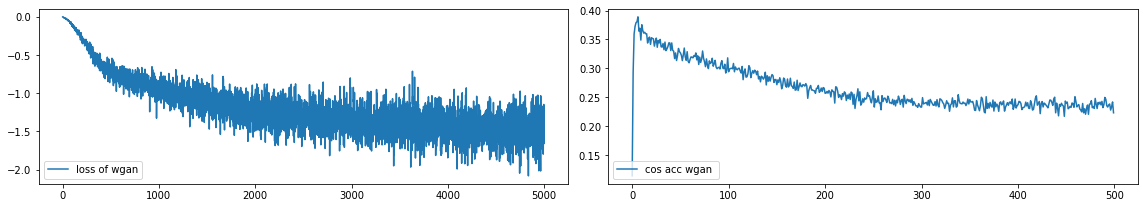

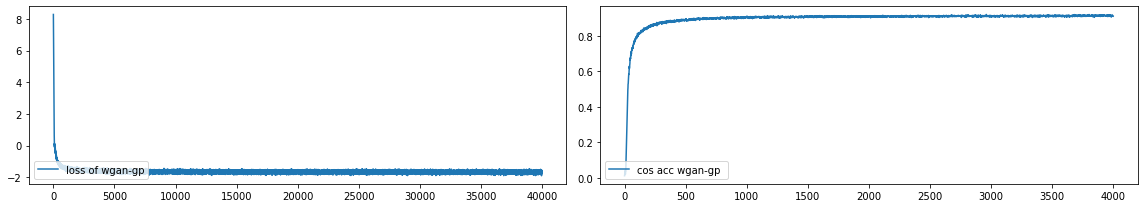

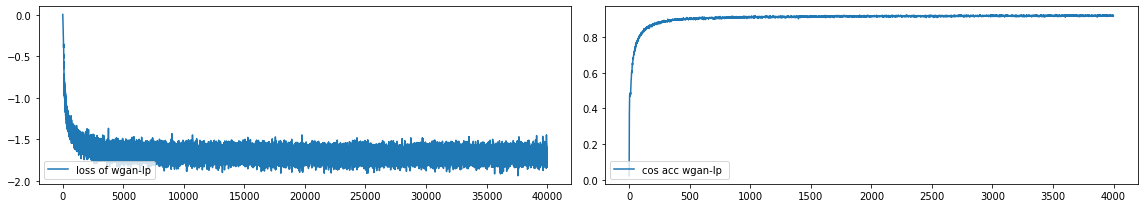

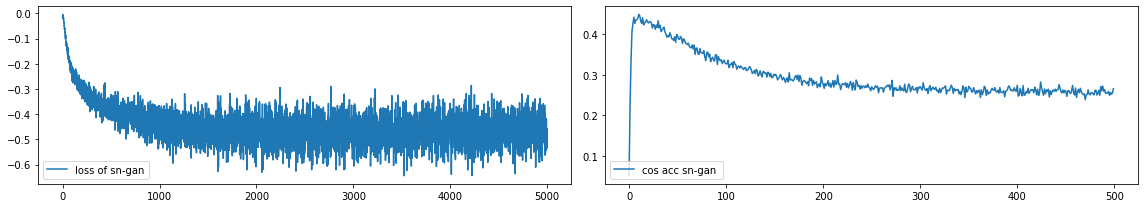

In [10]:
losses = {}
cos_accuracy = {}
critic_optimizer = {}
keys = [  'wgan','wgan-gp','wgan-lp','sn-gan']
flags = [ None,'GP','LP',None]
lmbds = {key:val for key, val in zip(keys,[0.,LAMBDA_GP,LAMBDA_LP,0.])}
num_iterations_WGAN = [NUM_ITERATIONS_WGAN, NUM_ITERATIONS_WGAN_GP,NUM_ITERATIONS_WGAN_LP,NUM_ITERATIONS_SN_GAN]
num_iterations_WGAN = {key: num_it for key, num_it in zip(keys,num_iterations_WGAN)}

critic_optimizer = {key:torch.optim.Adam(method[key].parameters(),lr = LR,betas=(0, 0.9)) for key in keys}

for key,flag in zip(keys,flags):
    
    method[key] = method[key].cuda()
    
    losses[key],cos_accuracy[key]=train_WGAN( 
    critic=method[key], 
    critic_optimizer=critic_optimizer[key],
    sampler_q=benchmark.output_sampler,
    sampler_p=benchmark.input_sampler,
    benchmark=benchmark,
    batch_size=BATCH_SIZE, 
    n_iterations=num_iterations_WGAN[key] ,
    flag_penalty=flag,
    lmbd=lmbds[key]
)
    # take WGAN  on CPU
    method[key]=method[key].cpu()
    del critic_optimizer[key]
    gc.collect(); torch.cuda.empty_cache()
    fig,ax = plt.subplots(1, 2, figsize=(16,3))
    ax[0].plot(losses[key],label='loss of {}'.format(key))
    ax[1].plot(cos_accuracy[key],label='cos acc {} '.format(key))
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    fig.tight_layout()

In [11]:
if DIM == 2:
    folder  = "../checkpoints/nd/dim_{}/width_{}".format(DIM , WIDTH)
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    for key in ['wgan','wgan-gp','wgan-lp','sn-gan']:
        path  = os.path.join(folder ,"method_{}.pt".format(key))
        torch.save(method[key].cpu().state_dict(),path)

## 2. CoWGAN : WGAN without GP

In [12]:
method['cowgan']  = Critic(HIDDEN_DIMS,"COWGAN",None, None)
critic_optimizer['cowgan'] = torch.optim.Adam(method['cowgan'].parameters(),lr=LR,betas=(0, 0.9))

In [13]:
method['cowgan'] = method['cowgan'].cuda()
losses_cowgan, cosine_cowgan=train_CoWGAN(method['cowgan'], critic_optimizer['cowgan'], 
                  benchmark.output_sampler, benchmark.input_sampler,benchmark,BATCH_SIZE, 
                 NUM_ITERATIONS_CoWGAN )

method['cowgan'] = method['cowgan'].cpu()
del critic_optimizer['cowgan']
gc.collect(); torch.cuda.empty_cache()

100%|███████████████████████████████████████████████████████████████████████████████| 15000/15000 [03:04<00:00, 81.08it/s]


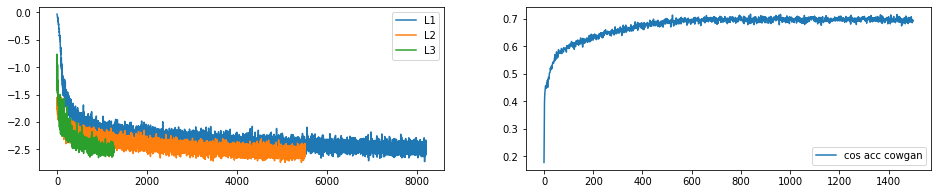

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_cowgan['L1'],label = 'L1')
ax[0].plot(losses_cowgan['L2'],label = 'L2')
ax[0].plot(losses_cowgan['L3'], label = 'L3')
ax[1].plot(cosine_cowgan, label = 'cos acc cowgan')
ax[0].legend()
ax[1].legend();

## 3. LSOT

In [15]:
method['lsot-f'] = Critic(HIDDEN_DIMS,"LSOT",None,None)
method['lsot-g'] = Critic(HIDDEN_DIMS,"LSOT",None, None)
critic_g_optimizer = torch.optim.Adam(method['lsot-g'].parameters(),lr=LR)
critic_f_optimizer = torch.optim.Adam(method['lsot-f'].parameters(),lr=LR)

In [16]:
method['lsot-f'] = method['lsot-f'].cuda()
method['lsot-g'] = method['lsot-g'].cuda()

losses_lsot,cos_acc_lsot = train_LSOT(method['lsot-f'],method['lsot-g'],critic_f_optimizer,critic_g_optimizer,
                    benchmark.output_sampler,benchmark.input_sampler,benchmark,
                    BATCH_SIZE,NUM_ITERATIONS_LSOT,  
                    EPSILON_LSOT)

method['lsot-f'] = method['lsot-f'].cpu()
method['lsot-g'] = method['lsot-g'].cpu()
del critic_g_optimizer , critic_f_optimizer
gc.collect(); torch.cuda.empty_cache()

100%|███████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:52<00:00, 88.71it/s]


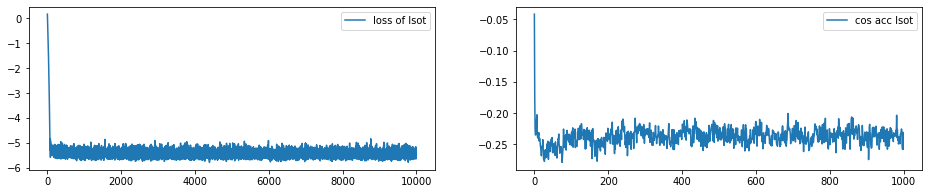

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_lsot,label = 'loss of lsot')
ax[1].plot(cos_acc_lsot, label = 'cos acc lsot')
ax[0].legend()
ax[1].legend();

## 4. 3P-WGAN

In [18]:
mover = Critic(HIDDEN_DIMS_MOVER,"3P-WGAN",None,None )
method['3p-wgan'] = Critic(HIDDEN_DIMS,"3P-WGAN",None,None)
critic_optimizer['3p-wgan']    =  torch.optim.Adam(method['3p-wgan'].parameters(), lr=LR,betas=(0.,0.9))
optimizer_mover      =  torch.optim.Adam(mover.parameters(), lr=LR, betas=(0.,0.9))

In [19]:
mover = mover.cuda()
method['3p-wgan']  = method['3p-wgan'].cuda()

losses_3p,cos_acc_3p = train_3PWGAN(method['3p-wgan'],
              mover,
              critic_optimizer['3p-wgan'],
              optimizer_mover,
              benchmark.output_sampler,
              benchmark.input_sampler,
              benchmark,
              BATCH_SIZE,
              NUM_ITERATIONS_3P_WGAN,
              MOVER_STEPS,
              reverse_flag=False)

method['3p-wgan'] = method['3p-wgan'].cpu()
mover = mover.cpu()
del critic_optimizer['3p-wgan'],optimizer_mover 
gc.collect(); torch.cuda.empty_cache()

100%|███████████████████████████████████████████████████████████████████████████████| 15000/15000 [18:00<00:00, 13.89it/s]


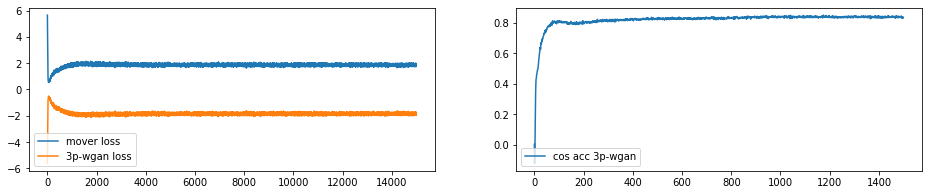

In [20]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_3p['mover'],label = 'mover loss')
ax[0].plot(losses_3p['critic'],label = '3p-wgan loss')
ax[1].plot(cos_acc_3p,label = 'cos acc 3p-wgan')
ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower left');

## 5. 3P-WGAN_REV

In [21]:
mover_rev = Critic(HIDDEN_DIMS_MOVER,"3P-WGAN",None,None )
method['3p-wgan_rev'] = Critic(HIDDEN_DIMS,"3P-WGAN",None,None)
critic_optimizer['3p-wgan_rev']     =  torch.optim.Adam(method['3p-wgan_rev'].parameters(), lr=LR, betas=(0.,0.9))
optimizer_mover_rev     =  torch.optim.Adam(mover_rev.parameters(), lr=LR, betas=(0.,0.9))

In [22]:
mover_rev = mover_rev.cuda()
method['3p-wgan_rev']  = method['3p-wgan_rev'].cuda()


losses_3p_r,cos_acc_3p_r = train_3PWGAN(method['3p-wgan_rev'],
              mover_rev,
             critic_optimizer['3p-wgan_rev'],
              optimizer_mover_rev,
              benchmark.output_sampler,
              benchmark.input_sampler,
              benchmark,
              BATCH_SIZE,
              NUM_ITERATIONS_MMR,
              MOVER_STEPS,
              reverse_flag=True,)

method['3p-wgan_rev'] = method['3p-wgan_rev'].cpu()
mover_rev = mover_rev.cpu()
del critic_optimizer['3p-wgan_rev'] , optimizer_mover_rev 
gc.collect(); torch.cuda.empty_cache()

100%|███████████████████████████████████████████████████████████████████████████████| 15000/15000 [17:53<00:00, 13.98it/s]


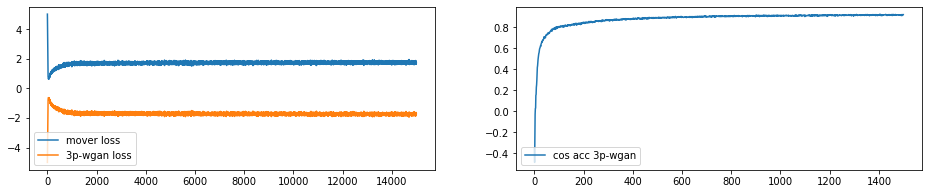

In [23]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_3p_r['mover'],label='mover loss')
ax[0].plot(losses_3p_r['critic'],label='3p-wgan loss')
ax[1].plot(cos_acc_3p_r,label = 'cos acc 3p-wgan')
ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower left');

## 7. SORT-OUT

In [24]:
method['sort-out'] = Critic_sort(HIDDEN_DIMS,NUM_UNITS)
critic_optimizer['sort-out'] = torch.optim.Adam(method['sort-out'].parameters(),lr=LR)

In [25]:
method['sort-out'] = method['sort-out'].cuda()


losses_so,cos_ac_so =  train_WGAN( 
    method['sort-out'], 
    critic_optimizer['sort-out'] ,
    sampler_q=benchmark.output_sampler,
    sampler_p=benchmark.input_sampler,
    benchmark=benchmark,
    batch_size=BATCH_SIZE,
    n_iterations=NUM_ITERATIONS_SORT_OUT,
    flag_penalty=None,
    lmbd = 0.)

method['sort-out'] = method['sort-out'].cpu()
del critic_optimizer['sort-out'] 
gc.collect(); torch.cuda.empty_cache()

100%|███████████████████████████████████████████████████████████████████████████████| 15000/15000 [07:26<00:00, 33.62it/s]


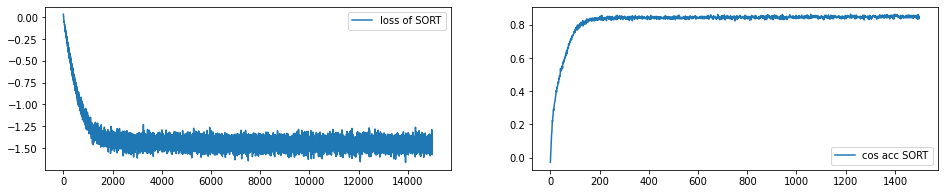

In [26]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_so,label = 'loss of SORT')
ax[1].plot(cos_ac_so, label = 'cos acc SORT')
ax[0].legend()
ax[1].legend();

## 8. WGAN-QP

In [27]:
method['wgan-qp'] =  Critic(HIDDEN_DIMS,"WG",None,None )
critic_optimizer['wgan-qp'] = torch.optim.Adam(method['wgan-qp'].parameters(),lr=LR)

In [28]:
method['wgan-qp'] = method['wgan-qp'].cuda()

loss_qp,cos_ac_qp = train_WGAN_qp(method['wgan-qp'], critic_optimizer['wgan-qp'],  benchmark.output_sampler ,
                     benchmark.input_sampler,benchmark,  BATCH_SIZE,
                  NUM_ITERATIONS_WGAN_QP )

method['wgan-qp'] = method['wgan-qp'].cpu()
del critic_optimizer['wgan-qp'] 
gc.collect(); torch.cuda.empty_cache()

100%|██████████████████████████████████████████████████████████████████████████████| 15000/15000 [02:13<00:00, 112.47it/s]


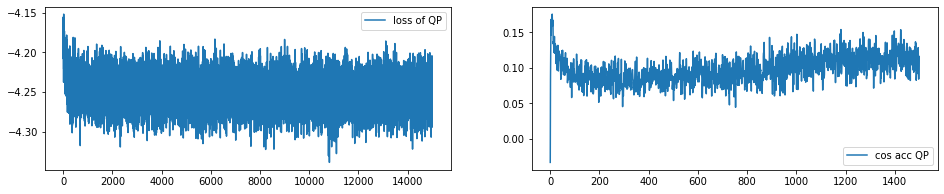

In [29]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(loss_qp,label='loss of QP')
ax[1].plot(cos_ac_qp, label='cos acc QP')
ax[0].legend()
ax[1].legend();

In [30]:
if DIM == 2:
    folder  = "../checkpoints/nd/dim_{}/width_{}".format(DIM , WIDTH)
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    for key in ['cowgan','lsot-f','3p-wgan','3p-wgan_rev','sort-out','wgan-qp']:
        path  = os.path.join(folder ,"method_{}.pt".format(key))
        torch.save(method[key].cpu().state_dict(),path)

## 9. Metrics

In [31]:
keys = ['wgan','wgan-gp','wgan-lp','sn-gan','cowgan','sort-out','3p-wgan','3p-wgan_rev','lsot-f','wgan-qp']
q_samples = benchmark.output_sampler.sample(BATCH_SIZE)
for key in keys:
    method[key] = method[key].cuda()
    q_samples.requires_grad = True
    print(key,(torch.autograd.grad(method[key](q_samples),q_samples,grad_outputs = torch.ones(q_samples.shape[0],1,
                                                        device = q_samples.device))[0].norm(dim=-1) <= 1).all().item())

wgan False
wgan-gp False
wgan-lp False
sn-gan True
cowgan False
sort-out True
3p-wgan False
3p-wgan_rev False
lsot-f True
wgan-qp True


In [32]:
cost = {}
cost['true'] = calculate_unbiased_wasserstein(benchmark,METRIC_SIZE)
 

for key in  ['wgan','wgan-gp','wgan-lp','sn-gan','3p-wgan','3p-wgan_rev','sort-out','lsot-f','wgan-qp','cowgan' ]:
    method[key] = method[key].cuda()
    cost[key] = calculate_kantorovitch_wasserstein( method[key] , key,
                                                       benchmark, METRIC_SIZE  ) 
    method[key] = method[key].cpu()

cost['dot'] = DOT_metrics(benchmark, METRIC_SIZE)[0] 

In [33]:
l2 = {}
 
for key in ['wgan','wgan-gp','wgan-lp','sn-gan','lsot-f','3p-wgan','sort-out','wgan-qp','cowgan']:
    if key in method.keys():
        method[key] = method[key].cuda()
        l2[key] = L2_metrics(method[key],None,benchmark, METRIC_SIZE,
                         flag_rev=False ) 
        method[key] = method[key].cpu()
        
mover_rev = mover_rev.cuda()
l2['3p-wgan_rev'] = L2_metrics(None,mover_rev ,benchmark, METRIC_SIZE,
                               flag_rev=True) 
mover_rev = mover_rev.cpu()

l2['dot'] = DOT_metrics(benchmark, METRIC_SIZE)[1].item()
l2['true'] = 0.

In [34]:
cos = {}
 
for key in ['wgan','wgan-gp','wgan-lp','sn-gan','lsot-f','3p-wgan','sort-out','wgan-qp','cowgan']:
    if key in method.keys():
        method[key] = method[key].cuda()
        cos[key] = cosine_metrics(method[key]  ,None,benchmark, METRIC_SIZE,flag_rev=False ) 
        method[key] = method[key].cpu()
 
        
mover_rev = mover_rev.cuda()
cos['3p-wgan_rev'] = cosine_metrics(None , mover_rev  ,benchmark, METRIC_SIZE,flag_rev=True
                                    ) 
mover_rev = mover_rev.cpu()


cos['dot'] = DOT_metrics(benchmark, METRIC_SIZE)[2].item()
cos['true'] = 1.0

In [35]:
results = {"cos" : cos , "l2" : l2, "cost" : cost}
results = pd.DataFrame(results)
results

,cos,l2,cost
wgan,0.239866,9.502037,1.588070
wgan-gp,0.912511,0.204940,1.813299
wgan-lp,0.921162,0.186918,1.806974
sn-gan,0.253818,1.353266,0.463312
lsot-f,-0.231390,1.365401,-0.204955
3p-wgan,0.831074,0.640947,1.757188
sort-out,0.850356,0.280229,1.460904
wgan-qp,0.090976,1.047632,0.001850
cowgan,0.693803,2.244444,2.536481
3p-wgan_rev,0.917654,0.157351,1.842741


In [36]:
path = "../metrics/metrics_nd/dim_{}/width_{}/".format(DIM,WIDTH)
if not os.path.exists(path):
    os.makedirs(path)
results.to_csv(os.path.join(path,"metrics_deg_{}_seed_{}.csv".format(DEG,SEED)))